<a href="https://colab.research.google.com/github/mlttac/AUNet_gwf/blob/main/Attention_U_Net_Gwf_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics guided Attention U-Net for steady State Groundwater Flow

The goal of this notebook is to model Steady State Groundwater flow using a Novel Machine Learning approach. We combine a Encoder-Decoder Neural network and a modifed loss function, incorporating physical system knowledge.  

We predict simple steady state groundwater flow by training an Attention U-Net using an image to image translation approach. 

![sample output_gwf](https://drive.google.com/uc?export=view&id=1-3mBj_HAnlP_ZS3stoOjUJe2QNpMEIHT)

The input is reduced to a tensor of (height $\times$ width $\times$ 3) with height and width of 64. The first dimension gives the head values defined at the boundaries, i.e. the well and boundary locations, the layer give a 0 or 1 whether a cell is a boundary cell. The last dimension is a Gaussian random field in which the hydraulic conductivity field K can have value belonging to one of 5 classes between 0.1 and 1: [0.1,0.28,0.46,0.64,0.82,1.]    
The target predictions are the simulation results performed by the  fully-implicit 3D finite difference model MODFLOW. 

We import the modules we need. 

In [ ]:
import pandas
(pandas. __version__)

'1.1.5'

In [ ]:
import tensorflow as tf
print(tf. __version__)
import numpy as np
import os
import time
from datetime import datetime
import pandas as pd

import matplotlib.colors as colors
from matplotlib import colors as c
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib import colors


from matplotlib import pyplot as plt
from IPython import display

from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from keras import backend as K

from keras.callbacks import Callback, LambdaCallback, LearningRateScheduler


# print(sys.version)
# print('numpy version: {}'.format(np.__version__))
# print('matplotlib version: {}'.format(mpl.__version__))

2.7.0


## Physics Loss Function

The physics term of the loss function is set as the residual in terms of the partial differential, in this case the fundamental governing equation for steady state groundwater flow, i.e.:

\begin{equation}
{\nabla\cdot (\mathbf{K}\nabla{h}}) = 0
\end{equation}

To calculate this a finite difference schema is incorporated into the loss function based on the Control-Volume Finite-Difference Flow Equation, corresponding to MODFLOW implementation:

\begin{equation}
\sum_{j=1}^{4}C_{i,j}(h_{i} - h_{j}) + P_{well}h_{well} = 0
\end{equation}

where h are nodes in the schema as shown in the following figure.

![Laplace 5 point FD Schema](https://drive.google.com/uc?export=view&id=1dHOIKdpLOlvR3HLQYgs_sMZvZkdqtQ17)

In the particular case of cell width =1: 

\begin{equation}
C_{i,j} = 2 \frac{k_{i} k_{j}}{k_{i} + k_{j}}
\end{equation}

and  the external sink/source term is calculated only for the input wells:

\begin{equation}
P_{well} = k_{i,well} ( 4 - \frac{\sum_{j=1}^{4}{h_{j}}}{h_{i,well}})
\end{equation}



### Setting up the FD Template

As a Finite Difference template is tructurally equivalent to a convolutional kernel, we use a customized convolution kernel following our FD schema.

In [ ]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=1)

headKernels2D = [ make_kernel([ [0., 1., 0.], [0., -1., 0.], [0., 0., 0.]]),
                  make_kernel([ [0., 0., 0.], [0., -1., 1.], [0., 0., 0.]]),
                  make_kernel([ [0., 0., 0.], [0., -1., 0.], [0., 1., 0.]]),
                  make_kernel([ [0., 0., 0.], [1., -1., 0.], [0., 0., 0.]])]

t1Kernels2D = [ make_kernel([[0., 0., 0.], [0., 1., 0.],[0., 0., 0.]]),
                make_kernel([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
                make_kernel([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
                make_kernel([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]])]

t2Kernels2D = [ make_kernel([[0., 1., 0.], [0., 0., 0.], [0., 0., 0.]]),
                make_kernel([[0., 0., 0.], [0., 0., 1.], [0., 0., 0.]]),    
                make_kernel([[0., 0., 0.], [0., 0., 0.], [0., 1., 0.]]),
                make_kernel([[0., 0., 0.], [1., 0., 0.], [0., 0., 0.]])]

Now that the FD schema is coded into a convolutional kernel ( *'headKernels2D'* ) we must provide a mechanism to use the kernel to evaluate the PDE.
 

In [ ]:
def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  #y_d = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='VALID')  # SAME
  y = tf.nn.conv2d(x, k, [1, 1, 1, 1], padding='VALID')
  # print( "x shape: {} , k shape: {}, y shape: {}".format(x.shape, k.shape, y.shape))
  return y[0, :, :, :,:]

def evalKernels(x, kernels):
    """Compute the 2D laplacian of an array"""
    vals = []
    for kernel in kernels:
        vals.append(simple_conv(x, kernel))
    return tf.concat(vals,-1)

By calling *'evalKernels'*, we will now evaluate the partial differential over the provided array. 

Let's make a small example. We define a random input head and apply the finite difference template on it. 

In [ ]:
heads = np.random.randint(low=0, high=10, size=[4, 4])
heads = tf.convert_to_tensor(heads, dtype=tf.float32)
dH_x = evalKernels(tf.expand_dims(heads, 0), headKernels2D)
headkernel0 = [[0., 1., 0.],[0., -1., 0.],[0., 0., 0.]]

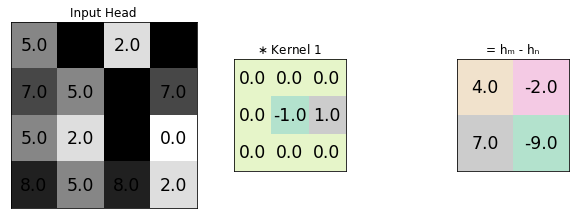

In [ ]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

kerneln = 1 # choose kernel number  
fig = plt.figure(figsize=(10, 10))
sub=[121, 132 , 133]
titles = ["Input Head" , r"$\ast$ Kernel {}".format(kerneln) , '= h{0} - h{1}'.format('\N{LATIN SUBSCRIPT SMALL LETTER M}','\N{LATIN SUBSCRIPT SMALL LETTER N}') ]
headKernel = headKernels2D[kerneln][:,:,0,0].numpy()
cmaps=['Greys','Pastel2', 'Pastel2' ]
item= [heads, headKernel, dH_x[0,:,:,kerneln]]

for i in range(len(titles)):
  ax = fig.add_subplot(sub[i])
  plt.title(titles[i])
  im = plt.imshow(item[i], cmap=cmaps[i],interpolation='nearest')
  for (j,i),label in np.ndenumerate(item[i]):
          ax.text(i,j, "{:.1f}".format(label), color='black', ha='center', va='center',size='xx-large')
          ax.set_xticks([])
          ax.set_yticks([])

plt.subplots_adjust(wspace=1)
plt.show()

### Loss Function

Now we must transform this simple convolution function into a loss function for our encoder-decoder. Typically with a loss function the comparison is between the groundtruth (*'y_true'*) and the prediction (*'y_pred'*) however the physics loss function is solely based on the prediction, as it the loss is based on the partial differential equation.

The calling routine is called with both input and prediction: the first gives the values of the hydraulic conductivities while the latter those of the predicted groundwater head. 

In [ ]:
def custom_loss(inp,tar ):
  trans = inp[:, :, :, 2] # hydraulic conductivity k
  head = tar[:, :, :, 0] # groundwater head h
  # Conductivity term
  Ti = evalKernels(trans, t1Kernels2D)
  Tj = evalKernels(trans, t2Kernels2D)
  C = tf.divide(tf.multiply(tf.constant(2.0), tf.multiply(Ti, Tj)), 
                tf.add(Ti, Tj))

  dH_x = evalKernels(head, headKernels2D)
  SUM_C_h = tf.expand_dims(tf.reduce_sum(tf.multiply(C, dH_x), 3), axis=-1)

  mask_inputhead = evalKernels(inp[:, :, :, 1], t1Kernels2D) # 1 on the well, 0 otherwise
  mask_inputhead = tf.add(1.0, -mask_inputhead) # 0 on the well, 1 otherwise
  SUM_C_h = tf.multiply(mask_inputhead[0], SUM_C_h)

  # tf.print (SUM_C_h.shape)
  #  External sink/source term
  # headsj = [make_kernel([[0., 1., 0.],[1., 0., 1.], [0., 1., 0.]])] 
  # hi = evalKernels(head, t1Kernels2D)
  # h_around = evalKernels(head, headsj)
  # Pm =  tf.multiply(Ti[0],(tf.subtract(tf.multiply(hi[0], 4),h_around[0])))
  # # Mask to apply Pm only where there is a pumping well  
  # mask_inputhead = evalKernels(inp[:, :, :, 1], t1Kernels2D)
  # P_well = tf.multiply(mask_inputhead[0], Pm)
  # output = tf.add(SUM_C_h, P_well)

  return  SUM_C_h

There are also other ways to implement the PDE into the loss function without considering the FD scheme. 
The following implementation [(*primal_residual_fc*)](https://github.com/cics-nd/pde-surrogate/blob/b39c8d3caec59fe7253f5cf7171558d83835a8a3/models/darcy.py#L13) takes the equation: 

\begin{equation}
{\nabla\cdot (\mathbf{K}\nabla{u}}) = 0
\end{equation}

and applies integration by parts ( div(fa)=fdiv(a)+∇f⋅a ). The loss function becomes: 

\begin{equation}
\mathbf{K} {\nabla\cdot (\nabla{u}})  + {\nabla{\mathbf{K}}} {\nabla{u}} = 0
\end{equation}

In [ ]:
def primal_residual(u, u_source, k, BATCH_SIZE = 1, CHANNELS = 1):

    u = tf.reshape(u, shape=(BATCH_SIZE, IMG_H, IMG_W, CHANNELS))
    k = tf.reshape(k, shape=(BATCH_SIZE, IMG_H, IMG_W, CHANNELS))
    dudx, dudy = tf.image.image_gradients(u)
    dkdx, dkdy = tf.image.image_gradients(k)
    du2dx = tf.image.image_gradients(dudx)[0]
    du2dy = tf.image.image_gradients(dudy)[1]

    div1 = dkdx * dudx + k * du2dx 
    div2 = dkdy * dudy + k * du2dy 
    div = div1[0,:, :, 0] + div2[0,:, :, 0]
    # WHY to the power of 2?!! 
    loss_pde= (div)**2 
    loss_pde_mean = tf.reduce_mean(loss_pde) 
    return div1[0,:, :, 0], div2[0,:, :, 0]


## Load the dataset

We load the dataset generated with the 3D finite difference model MODFLOW. 

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive/')
  path = '/content/gdrive/My Drive/Colaboratory/Datasets'
  folder_path = "/content/gdrive/My Drive/Colaboratory/ED"
else:
  print('Not running on CoLab')
  path = 'C:/Colab/AUnet'
  folder_path = "C:/Colab/AUnet"
  # path = 'D:/Development/Machine Learning/Neural Networks/MLFlow/Data Generator_Latest/gwf.npz'

Running on CoLab
Mounted at /content/gdrive/


In [ ]:
with np.load(os.path.join(path, "40000_samples.npz")) as data:
  train_examples_loaded = tf.cast(data['x_train'], tf.float32)
  train_labels_loaded = tf.cast(data['y_train'], tf.float32)
  test_examples = tf.cast(data['x_test'], tf.float32)
  test_labels = tf.cast(data['y_test'], tf.float32)
  # valid_examples = tf.cast(data['x_validation'], tf.float32)
  # valid_labels = tf.cast(data['y_validation'], tf.float32)

Split the training dataset into 70% for training and 30% for testing. 

In [ ]:
# Function to find the number closest
# to n and divisible by m
def closestNumber(n, m) :
	q = int(n / m)
	n1 = m * q
	if((n * m) > 0) :
		n2 = (m * (q + 1))
	else :
		n2 = (m * (q - 1))
	if (abs(n - n1) < abs(n - n2)) :
		return n1
	return n2
	
BATCH_SIZE = 40
train_examples_30per = 0.2 * train_examples_loaded.shape[0] 
# get the closest number to the 80% of sample which is divisible by the batch size
N_TRAIN = closestNumber(train_examples_30per, BATCH_SIZE)

valid_examples = train_examples_loaded[-N_TRAIN:]
valid_labels = train_labels_loaded[-N_TRAIN:]
train_examples = train_examples_loaded[:-N_TRAIN]
train_labels = train_labels_loaded[:-N_TRAIN]

print("Shape of training tensor (batch - width - height - features):", train_examples.shape)
print("Shape of training labels tensor:", train_labels.shape)
print("Shape of test tensor:", test_examples.shape)
print("Shape of validation tensor:", valid_examples.shape)

N_TRAIN = train_examples.shape[0] 
BUFFER_SIZE = N_TRAIN
IMG_H = 64
IMG_W = 64
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset_original = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))
test_dataset = test_dataset_original.batch(BATCH_SIZE)

valid_dataset_original = tf.data.Dataset.from_tensor_slices((valid_examples, valid_labels))
valid_dataset = valid_dataset_original.batch(BATCH_SIZE)


Shape of training tensor (batch - width - height - features): (32000, 64, 64, 3)
Shape of training labels tensor: (32000, 64, 64, 1)
Shape of test tensor: (4000, 64, 64, 3)
Shape of validation tensor: (8000, 64, 64, 3)


Let's visualize a random sample and the corresponding physics loss. 

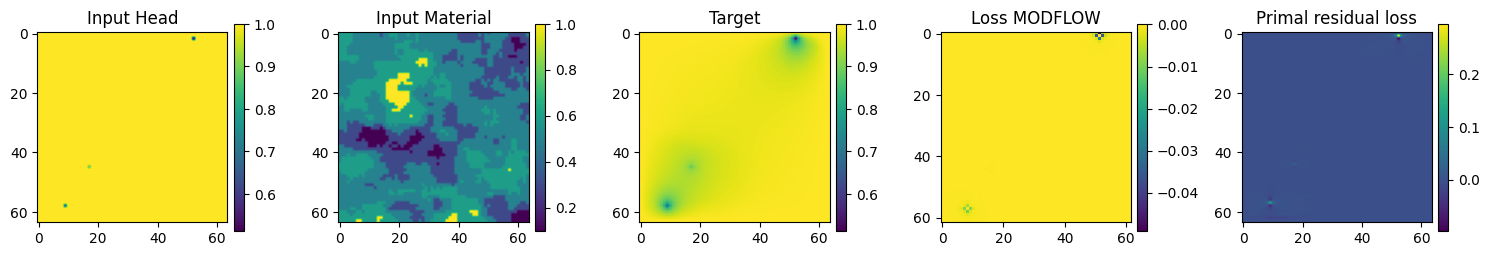

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import random 

def fig_losses(inp, tar):
  loss_primal, loss_primal2 = primal_residual( tar[:, :, 0], inp[:, :, 0], inp[:, :, 2])
  loss_modflow = custom_loss(tf.expand_dims(inp,axis=0), tf.expand_dims(tar,axis=0) )
  plt.figure(figsize=(15,15))
  display_list = [inp[:, :, 0], inp[:, :, 2], tar[:, :, 0],loss_modflow[0,:, :, 0], loss_primal ]
  title = ['Input Head', 'Input Material', 'Target', 
           'Loss MODFLOW', 'Primal residual loss']

  for i in range(len(display_list)):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    im = plt.imshow(display_list[i])
    plt.colorbar(im,fraction=0.05, pad=0.03)
    #plt.axis('off')

  plt.tight_layout()
  plt.show()
  return loss_modflow, loss_primal

n = random.randint(0, N_TRAIN)
inp = train_examples[n]
tar = train_labels[n]
loss_modflow, loss_primal = fig_losses(inp, tar)

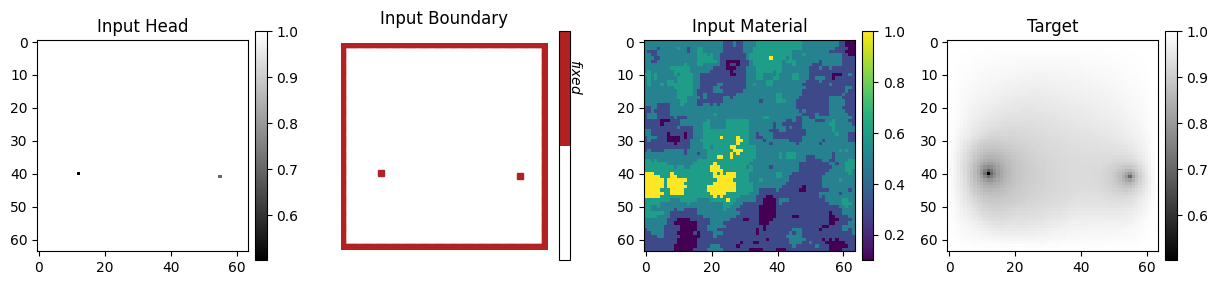

In [ ]:
def plot_boundary(Xboundary, title=None):
    cmap = colors.ListedColormap(['white', 'firebrick'])
    #norm = colors.BoundaryNorm([0,1,1], cmap.N)
    img = plt.spy(Xboundary, markersize=5, precision=0.1, origin="lower", color = 'firebrick')
    # img = plt.imshow(Xboundary, origin='lower',cmap=cmap, norm=norm)
    cbar = plt.colorbar(plt.imshow(Xboundary,cmap = cmap),fraction=0.05)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.text(0.8, 0.8, '$fixed$', ha='left', va='center', rotation=270)
    if title:
      plt.title(title)
    plt.axis('off')
    return plt


def fig_inputs(inp, tar):
  plt.figure(figsize=(15,15))
  display_list = [inp[:, :, 0], inp[:, :, 1],inp[:, :, 2], tar[:, :, 0]]
  title = ['Input Head', 'Input Boundary', 'Input Material', 'Target']

  for i in range(len(display_list)):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    if i==1:
      plot_boundary(display_list[i])
    elif i==0 or i==3:
      im = plt.imshow(display_list[i], cmap= 'gray')
      plt.colorbar(im,fraction=0.05, pad=0.03)
    else:
      im = plt.imshow(display_list[i])
      plt.colorbar(im,fraction=0.05, pad=0.03)

  plt.tight_layout()
  plt.show()
  return 

n = random.randint(0, N_TRAIN)
inp = train_examples[n]
tar = train_labels[n]
fig_inputs(inp, tar)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
fig = make_subplots(rows=1, cols=2, subplot_titles=("Input", "Target"))

img = px.imshow(inp[:, :, 0])
fig.add_trace(img.data[0])
fig.update_yaxes(autorange="reversed") #y-axis is reversed by default 

img = px.imshow(tar[:, :, 0])
fig.add_trace(img.data[0],row=1, col=2)

## Network Architecture


Now that we have our loss function, now lets create the encoder-decoder to produce an estimate of our steady state groundwater flow.

The architecture of is an Attention U-Net from [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/abs/1804.03999)  written by Oktay et. al. 

  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (: Upsampling + Conv2D -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
  * Soft attention implemented at the skip connections
  * We are able to fix know boundary values in the results and output values in the fixed target range [0.5,1].

It looks like: 

![attention gate](https://drive.google.com/uc?export=view&id=1nmpZSdvhxD7x87CixR9QnLhmQyx70a0x)



In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]

    return tf.keras.layers.Lambda(func)

### Encoder and Decoder
Define the downsampler (encoder):

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
inp_tensor = tf.random.uniform(shape=[32, 32, 64])
down_model = downsample(128, 4)
down_result = down_model(tf.expand_dims(inp_tensor, 0))
print (down_result.shape)

In [ ]:
down_model.summary()

In [ ]:
# table=pd.DataFrame(columns=["Input Shape"])
# for layer in model.layers:
#     table = table.append({"Input Shape":layer.input_shape}, ignore_index=True)
# table

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  # result.add(
  #   tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
  #                                   padding='same',
  #                                   kernel_initializer=initializer,
  #                                   use_bias=False))

  result.add(tf.keras.layers.UpSampling2D(size, interpolation='bilinear' ))
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False)) #changed padding


  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  
  return result

In [ ]:
inp_tensor = tf.random.uniform(shape=[16, 16, 256])
up_model = upsample(64,4)
up_result = up_model(tf.expand_dims(inp_tensor, 0)) 
print (up_result.shape)

In [ ]:
up_model.summary()

### Attention block

We implement the attention gates as defined by Oktay et. al. The attention gate takes the vectors x and g as inputs. The vector g is taken from the next lowest layer of the network in the upsampling path, while x is the corresponding vector from the encoder going through the skip connection. Vector x goes through a strided convolution and vector g goes through a 1x1 convolution such that their dimensions become the same and the two vectors are summed element-wise. The resulting weights are larger if aligned while unaligned weights become relatively smaller. The resultant vector goes through a ReLU activation layer, a 1x1 convolution and a sigmoid layer which scales the vector between the range [0,1. The attention coefficients are upsampled to the original dimensions of the x vector and are multiplied element-wise to the original x vector, scaling the vector according to relevance. The resulting vector is then passed along in the skip connection as normal. 

![attention gate](https://drive.google.com/uc?export=view&id=11_1q9yyl9ZFOTG6sNNFgpMKBvBkbhwoT)

In [ ]:
from tensorflow.keras import backend as K

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tf.keras.layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = tf.keras.layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tf.keras.layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tf.keras.layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16
    concat_xg = tf.keras.layers.add([upsample_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    
    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = tf.keras.layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])
    y = tf.keras.layers.multiply([upsample_psi, x])
    result = tf.keras.layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tf.keras.layers.BatchNormalization()(result)
    return result_bn

In [ ]:
inp_tensor = tf.random.uniform(shape=[16, 16, 256])
gating_model_result = gating_signal(input= tf.expand_dims(inp_tensor, 0), out_size=64, batch_norm=True)
print (gating_model_result.shape)

In [ ]:
inp_tensor_skip = tf.random.uniform(shape=[ 32, 32, 64])
attention_block_result = attention_block(x = tf.expand_dims(inp_tensor_skip, 0), gating=gating_model_result, inter_shape=64)
print (attention_block_result.shape)

### Attention U-net
Define the network with the downsampler and upsampler and the attention gates:

In [ ]:
def fixBoundary(args):
  x, B, H = args
  return tf.where(B > 0.5, H, x)

def get_range(input, target_max, target_min):
  return input * (target_max - target_min) + target_min

In [ ]:
def Encoder_Decoder_attention():
  inputs = tf.keras.layers.Input(shape=[IMG_H,IMG_W,3])
  # H = crop(3, 0, 1)(inputs)
  # B = crop(3, 1, 2)(inputs)

  filter_size = 4
  down_stack = [
    downsample(64, filter_size, apply_batchnorm=False), 
    downsample(128, filter_size),
    downsample(256, filter_size), 
    downsample(512, filter_size), 
    # downsample(512, filter_size), 
    # downsample(512, 2), 
  ]

  up_stack = [
    # upsample(512, filter_size, apply_dropout=True), 
    # upsample(512, filter_size, apply_dropout=True), 
    upsample(256, filter_size, apply_dropout=True), 
    upsample(128, filter_size, apply_dropout=True), 
    upsample(64, filter_size), # (bs, 32, 32, 128)
  ]


  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, filter_size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])

  FILTER_NUM = [512, 512, 256, 128, 64]
  # Upsampling and establishing the skip connections
  for i, (up, skip) in enumerate(zip(up_stack, skips)):
    gating_i = gating_signal(x, FILTER_NUM[i], batch_norm= True)
    att = attention_block(skip, gating_i, FILTER_NUM[i])
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, att])
    
  x = last(x)
  
  x = tf.keras.layers.Lambda(get_range, arguments={'target_max': 1, 'target_min': 0.5})(x)

  # x = tf.keras.layers.Lambda(fixBoundary)([x,B,H])
  
  return tf.keras.Model(inputs=inputs, outputs=x) 

In [ ]:
model = Encoder_Decoder_attention()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
import pandas as pd
table=pd.DataFrame(columns=["Name", "Parameters"])
for layer in model.layers:
    table = table.append({"Name":layer.name, "Parameters":layer.count_params()}, ignore_index=True)
table
#     name = layer.name
#     input_shape = layer.input_shape
#     output_shape = layer.output_shape
#     count_params = layer.count_params()
from google.colab import files
table.to_csv('data.csv')
# files.download("data.csv")

## Callbacks



### Plot Images

Write some function to plot images during training.

In [ ]:
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)

def generate_images(model, test_input, target):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0, :, :, 0], test_input[0, :, :, 1], 
                  test_input[0, :, :, 2], target[0, :, :, 0], 
                  prediction[0, :, :, 0], 
                  abs(target[0, :, :, 0]-prediction[0,:,:,0])]
  title = ['Input Head', 'Input Boundaries', 'Input Field', 'Target', 
           'Predicted Image', 'Abs Error']

  for i in range(len(display_list)):
    plt.subplot(1, 7, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    im = plt.imshow(display_list[i])
    plt.colorbar(im, fraction=0.05, pad=0.03)
    plt.axis('off')

mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
def fig_training_error(model, test_input, target):
  prediction = model(test_input, training=True)
  #loss_primal, loss_primal2 = primal_residual( tar[:, :, 0], inp[:, :, 0], inp[:, :, 2])
  loss_modflow = custom_loss(test_input[0,:,:,:], prediction[0,:,:,:])


  reserr = target[0, :, :, 0]-prediction[0,:,:,0]
  # mean absolute error 
  abs_reserr = tf.math.abs(reserr)
  # mean absolute percentage error 
  ape = 100 * tf.math.abs(reserr / target[0, :, :, 0])
  plt.figure(figsize=(15,15))

  display_list = [target[0, :, :, 0], 
                  prediction[0, :, :, 0], 
                  test_input[0, :, :, 2],
                  reserr, loss_modflow]
  title = ['y', r'$\hat{y}$', 'Input Field', r'$ y - \hat{y}$', 'Loss Modflow']
  bounds = np.linspace(0.5, 1, 26)
  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
  divnorm=c.TwoSlopeNorm(vcenter=0.)
  norm_list= [norm, norm, None, divnorm, None]
  cmap_list =['viridis', 'viridis', None, 'RdBu', 'RdBu']

  for i in range(len(display_list)):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    im = plt.imshow(display_list[i], norm=norm_list[i], cmap=cmap_list[i])
    plt.colorbar(im, fraction=0.05, pad=0.03)
    plt.axis('off')
    
  return loss_modflow


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

In [ ]:
# Two ways to display the target and prediction images during training 
# first way
class GenerateImages(Callback):
    def on_epoch_end(self, epoch, logs):
        for example_input, example_target in test_dataset_original.shuffle(100).batch(1).take(1):
          generate_images(model, example_input[:,:,:,:], example_target)
          fig_training_error(model, example_input[:,:,:,:], example_target)
generateimages = GenerateImages()

#second way
def testmodel(epoch, logs):
    for example_input, example_target in test_dataset.take(1):
        generate_images(model, example_input[:,:,:,:], example_target)
# Callback to display the target and prediciton
testmodelcb = LambdaCallback(on_epoch_end=testmodel)

### Checkpoint 
We define a checkoint to save the model every 10 epochs. 
We also define an early stopping callback (we won't be using it though). 

In [ ]:
def dir_checkpoints(folder_path, model_name = '', app=True):
    folder_path = os.path.dirname(folder_path)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min') 
    checkpoint_path = os.path.join(folder_path, 'cp-{epoch:04d}.h5') #ckpt
    checkpoint_dir = os.path.dirname(checkpoint_path)
    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        # filepath=checkpoint_path, save_freq=10*BATCH_SIZE) #save every 10 epochs
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, save_best_only=True, monitor="val_loss",
        verbose=1)

    hystory_filename = os.path.join(folder_path, 'model_history_callback.csv')
    history_logger=tf.keras.callbacks.CSVLogger(hystory_filename, separator=",", append=app)
    return early_stopping_callback, model_checkpoint_callback, history_logger


### Tensorboard - Not Used


In [ ]:
# !pip install -q -U tensorboard
# # Load the TensorBoard notebook extension.
# %load_ext tensorboard
# import tensorboard
# tensorboard.__version__
# # Define the Keras TensorBoard callback.
# logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

### Learning Schedule - Not Used

Define and visualize a learning schedule. 

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  8e-4,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1)

lr_schedule_SGD = tf.keras.optimizers.schedules.InverseTimeDecay(
  1.0,
  decay_steps=STEPS_PER_EPOCH*5,
  decay_rate=1)

step = np.linspace(0,10000)
lr = lr_schedule(step)
lr_SGD = lr_schedule_SGD(step)

plt.figure(figsize = (8,6))
# plt.plot(step/STEPS_PER_EPOCH, lr, label ="learning rate decay")
plt.plot(step/STEPS_PER_EPOCH, lr_SGD, label ="learning rate decay sgd")
#plt.ylim([0,max(plt.ylim())])
plt.legend(loc="upper right")
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [ ]:
# # print(step/STEPS_PER_EPOCH, lr)
# for item_a, item_b in zip(step/STEPS_PER_EPOCH, lr):
#     print("{:.0f}".format(item_a), 10*" ", "{:.0e}".format(item_b.numpy()))

## Training

We define a custom loss for the FD scheme and a custom metrics for the coefficient of determination. 

In [ ]:
alpha = 1
def FD_loss(gen_output, input_data):
    return alpha * tf.reduce_mean(tf.pow(custom_loss(input_data, gen_output), tf.constant(2.0)))

def custom_max(y_true, y_pred):
    return tf.math.reduce_max(tf.math.abs(y_true[:,:,:,0] - y_pred[:,:,:,0]))

beta = 0
def custom_mse(y_true, y_pred):
    return beta * tf.math.reduce_sum(tf.square(y_true[:,:,:,0] - y_pred[:,:,:,0]))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
import csv
class StoreModelHistory(Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir(folder_path)):
      with open(folder_path+'model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open(folder_path+'model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)



In [ ]:
# Prepare a directory to store all the checkpoints.
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

folder_path = "/content/gdrive/My Drive/Colaboratory/ED/DS_dropout50/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

def get_compiled_model():
    model = Encoder_Decoder_attention()
    # FD = FD_loss(gen_output = model.output , input_data=model.input)
    #model.add_loss( FD)
    # model.add_metric(FD, name='Physics loss')
    model.compile(loss = tf.keras.losses.MeanSquaredError(), #custom_mse, #custom_L1, #tf.keras.losses.MeanAbsoluteError(), # tf.keras.losses.MeanSquaredError() 
                  # optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                  # optimizer= tf.keras.optimizers.SGD(learning_rate= 0.01, momentum=0.9999), #, momentum=0.9999
                  optimizer=tf.keras.optimizers.Adam(8e-4), 
                  metrics =[tf.keras.metrics.RootMeanSquaredError(name = 'RMSE'), coeff_determination, tf.keras.metrics.MeanSquaredError(name='MSE Loss'),
                            custom_max])
    return model

dependencies = {
    'coeff_determination': coeff_determination, 
    'custom_max': custom_max
}

def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [folder_path + "/" + name for name in os.listdir(folder_path)]
    csv_logger = [x for x in checkpoints if x.endswith(('.csv'))]
    checkpoints = [x for x in checkpoints if x.endswith((".h5", ".hdf5", '.ckpt'))]
    # checkpoints = filter(lambda x:x.endswith((".h5", ".hdf5", '.ckpt')), checkpoints)
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        model = tf.keras.models.load_model(latest_checkpoint, custom_objects=dependencies)
        with open(csv_logger[0]) as f:      # you use your training log to get the right epoch number
          i_epoch = sum(1 for line in f) - 2
        app=True                            # you want to append to the log file
        print("Restoring from {}, re-starting training at epoch {}". format(os.path.basename(latest_checkpoint),i_epoch ) )
        return i_epoch, model, app

    model = get_compiled_model()
    i_epoch=-1                          # you need this to start at epoch 0
    app=False                           # you want to start logging from scratch
    print("Creating a new model")
    return i_epoch, model, app

i_epoch, model, app = make_or_restore_model()
model_name = "alpha{}_beta{}_{}".format(alpha, beta, N_TRAIN)
early_stopping_callback, model_checkpoint_callback, history_logger = dir_checkpoints(folder_path, model_name = model_name, app=app)


print("Fit model on training data")
history = model.fit(
    train_dataset,
    batch_size=40,
    validation_data = (valid_examples, valid_labels), 
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=100,
    initial_epoch = i_epoch+1,
    callbacks=[PlotLossesKeras(), model_checkpoint_callback, early_stopping_callback, history_logger, StoreModelHistory()], 
    verbose = 1
)


If instead we want to evaluate a saved model, we run the cell below: 

In [ ]:
# %tensorboard --logdir logs

dependencies = {
    'coeff_determination': coeff_determination, 
    'custom_max': custom_max,
    'custom_mse':custom_mse
}

folder_path = "/content/gdrive/My Drive/Colaboratory/ED/"
model_noatt  = tf.keras.models.load_model(os.path.join(folder_path, "DS_BNdropout_UpperLayers_NoATT/cp-0133.h5")  , 
                                    custom_objects=dependencies) 
model_att  = tf.keras.models.load_model(os.path.join(folder_path, "DS_BNdropout_UpperLayers/cp-0133.h5")  , 
                                    custom_objects=dependencies)
model = model_att

In [ ]:
model_att_39  = tf.keras.models.load_model(os.path.join(folder_path, "cp-0039_Att.h5")  , 
                                    custom_objects=dependencies)

OSError: ignored

In [ ]:
import pandas as pd
folder_path = "/content/gdrive/My Drive/Colaboratory/ED/40000samples/"
history_dataframe = pd.read_csv(os.path.join(folder_path, 'model_history_MSEonly.csv'), sep=',')
history_dataframe_FD = pd.read_csv(os.path.join(folder_path, 'model_history_physics.csv'), sep=',')

## Analyze results

### Predictions on test/train data

In [ ]:
def show_n_predictions(examples, labels, title, n = 10):
    prediction = model(examples, training=True).numpy()
    
    fig = plt.figure(figsize=(10, 50))
    
    bounds = np.linspace(0.5, 1, 26)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    prev = 0 
    for i in range(n):
      if i%2==1:
        # display original
        ax = plt.subplot(n, 2, i)
        im= plt.imshow(labels[i, :, :, 0], norm =norm, cmap= 'gray')
        plt.title("target")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.colorbar(im)

        # display reconstruction
        ax = plt.subplot(n, 2, i + 1)
        im = plt.imshow(prediction[i, :, :, 0], norm =norm, cmap= 'gray') #, norm =norm
        plt.colorbar(im)
        plt.title("prediction PIS")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=0.965)
    plt.show()
    return 

show_n_predictions(test_examples[:20,:,:,:], test_labels[:20,:,:,:], title= "Prediction on test data")

### Model Evaluation on test data

In [ ]:
model.evaluate(test_examples, test_labels, verbose=1)
# preds  = model(test_examples, training=False)
folder_path = "/content/gdrive/My Drive/Colaboratory/ED/DS_BNdropout_UpperLayers/"

evaluation = [] 
for filename in os.listdir(folder_path):
    if filename.endswith('0.h5') or filename.endswith('7.h5'):
        start = filename.find("cp-") + len("cp-")
        end = filename.find(".h5")
        substring = filename[start:end]
        model_loop  = tf.keras.models.load_model(os.path.join(folder_path, filename)  , 
                                            custom_objects=dependencies) 
        evaluation.append([int(substring)] + model_loop.evaluate(test_examples, test_labels, verbose=1))
        del model_loop

df = pd.DataFrame(evaluation, columns=['epoch','loss','RMSE','coeff_determination','MSE Loss','custom_max'])
print(df)
# df.to_csv(folder_path+'model_evaluation.csv')

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('No. epoch')
ax1.set_ylabel('MSE', color=color)
ax1.plot(df['epoch'], df['MSE Loss'],'--',color=color, label='MSE - Attention U-Net')
ax1.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coefficient of Determination $R^2$',  color=color)  # we already handled the x-label with ax1
ax2.set_ylim([0.8,1])
ax2.plot(df['epoch'], df['coeff_determination'], '-.',color=color, label= '$R^2$ - Attention U-Net')
# ax2.plot(history_dataframe_ref['coeff_determination'].rolling(window=12).mean(), ':', color=color, label= '$R^2$ - Attention U-Net')

ax2.tick_params(axis='y', labelcolor=color)

# ax2.legend(loc='upper right')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=7)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.suptitle('RMSE and $R^2$ during training', y=1.05)
plt.show()


### Losses

In [ ]:
# history_loaded = history.history
history_loaded = history_dataframe
history_dataframe_FD.keys()

In [ ]:
plt.plot(history_loaded['loss'], label='DS (train set)')
plt.plot(history_loaded['val_loss'], '-.',label='DS (validation set)')

plt.plot(history_dataframe_FD['MSE Loss'], '--', label='PS (train set)')
plt.plot(history_dataframe_FD['val_MSE Loss'], ':',label='PS (validation set)')

# plt.plot(history_loaded['Physics loss'], label='Physics Loss')
plt.plot(history_loaded['MSE Loss'], label='MSE')

# plt.yscale('log')
plt.ylim([0, 0.0001])
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

In [ ]:
folder_path = "/content/gdrive/My Drive/Colaboratory/ED/"
history_dataframe_ref = pd.read_csv(os.path.join(folder_path, 'DS_BNdropout_UpperLayers/model_history_callback.csv'), sep=',')
history_dataframe_NoAtt = pd.read_csv(os.path.join(folder_path, 'DS_BNdropout_UpperLayers_NoATT/model_history_callback.csv'), sep=',')

In [ ]:
plt.plot(history_dataframe_NoAtt['loss'], label='U-Net (train set)')
plt.plot(history_dataframe_NoAtt['val_loss'].rolling(window=12).mean(), label='U-Net (validation set)')

plt.plot(history_dataframe_ref['loss'],  '-.', label='Attention U-Net (train set)')
plt.plot(history_dataframe_ref['val_loss'].rolling(window=12).mean(), '-.',label='Attention U-Net (validation set)')

plt.yscale('log')
# plt.title('Loss')
# plt.ylim([0, 0.00006])
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

In [ ]:
plt.plot(history_loaded['loss'], label='DDS (train set)')
plt.plot(history_loaded['val_loss'], '-.',label='DDS (validation set)')

# plt.plot(history_dataframe_FD['loss'], '--', label='PIS (train set)')
# plt.plot(history_dataframe_FD['val_loss'], ':',label='PIS (validation set'))

# plt.plot(history.history['Physics loss'], label='Physics Loss')
# plt.plot(history_loaded['MSE Loss'], label='MSE Loss')

# x = np.linspace(0, 37, num=38)
# y = history_loaded['val_loss']
# model2 = np.poly1d(np.polyfit(x, y, 1))
# plt.plot(x, model2(polyline), color='red')

plt.yscale('log')
# plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

In [ ]:
plt.plot(history_dataframe_FD['loss'], '-', label='L')
#plt.plot(history_dataframe_FD['val_loss'], '--',label='Loss for PIS (validation data)')
plt.plot(history_dataframe_FD['Physics loss'], '-.', label="$L_{PDE}$")
plt.plot(history_dataframe_FD['MSE Loss'], '--', label="$L_{MSE}$")

plt.yscale('log')
# plt.title('Loss for PIS')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")



In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('No. epoch')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(history_dataframe_NoAtt['RMSE'].rolling(window=12).mean(),'--',color=color, label='RMSE - U-Net (test set)')
ax1.plot(history_dataframe_ref['RMSE'].rolling(window=12).mean(), color=color, label= 'RMSE - Attention U-Net (test set)')
ax1.plot(history_dataframe_NoAtt['val_RMSE'].rolling(window=12).mean(),'--',color='black', label='RMSE - U-Net (validation set)')
ax1.plot(history_dataframe_ref['val_RMSE'].rolling(window=12).mean(), color='black', label= 'RMSE - Attention U-Net (validation set)')
ax1.set_yscale('log')
ax1.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coefficient of Determination $R^2$',  color=color)  # we already handled the x-label with ax1
ax2.set_ylim([0.8,1])
ax2.plot(history_dataframe_NoAtt['coeff_determination'].rolling(window=12).mean(), '-.',color=color, label= '$R^2$ - U-Net (test set)')
ax2.plot(history_dataframe_ref['coeff_determination'].rolling(window=12).mean(), ':', color=color, label= '$R^2$ - Attention U-Net (test set)')
ax2.plot(history_dataframe_NoAtt['val_coeff_determination'].rolling(window=12).mean(), '-.',color='b', label= '$R^2$ - U-Net (validation set)')
ax2.plot(history_dataframe_ref['val_coeff_determination'].rolling(window=12).mean(), ':', color='b', label= '$R^2$ - Attention U-Net (validation set)')
ax2.tick_params(axis='y', labelcolor=color)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=(1.2,0.2))

plt.show()


### Attention coefficient visualization

In [ ]:
dictionary_layers = {i: v for i, v in enumerate(model.layers)}
# the attention layer is the lambda layer preceeding the multiply layer
att_ind = [(key-1) for key, value in dictionary_layers.items() if 'Multiply' in str(value)]
# the downsampling layers are the first 6 sequential layers
down_ind = [key for key, value in dictionary_layers.items() if 'sequential' in str(value)][:6]
# the downsampling layers are the 5 concatenate layers
up_ind = [key for key, value in dictionary_layers.items() if 'Concatenate' in str(value)]

In [ ]:
folder_path = "/content/gdrive/My Drive/Colaboratory/ED/"
model_25  = tf.keras.models.load_model(os.path.join(folder_path, "DS_BNdropout_UpperLayers/cp-0012.h5") , 
                                    custom_objects=dependencies)
model_50  = tf.keras.models.load_model(os.path.join(folder_path, "DS_BNdropout_UpperLayers/cp-0037.h5") , 
                                    custom_objects=dependencies)
model_MSE = model_noatt
# model_MSE  = tf.keras.models.load_model(os.path.join(folder_path, "cp-0150.h5") , 
#                                     custom_objects=dependencies)

In [ ]:
att_layer_outputs=[]
att_layer_outputs_25 = []
att_layer_outputs_50 = []
att_layer_outputs_MSE = []
for ind in att_ind:
  layer_name = model.layers[ind].name
  att_layer_outputs.append(model.get_layer(layer_name).output)
  att_layer_outputs_25.append(model_25.get_layer(layer_name).output)
  att_layer_outputs_50.append(model_50.get_layer(layer_name).output)
  


dictionary_layers = {i: v for i, v in enumerate(model_MSE.layers)}
# the attention layer is the lambda layer preceeding the multiply layer
att_ind = [(key-1) for key, value in dictionary_layers.items() if 'Multiply' in str(value)]
for ind in att_ind:
  layer_name = model_MSE.layers[ind].name
  att_layer_outputs_MSE.append(model_MSE.get_layer(layer_name).output)
# down_layer_outputs=[]
# for ind in down_ind:
#   layer_name = model.layers[ind].name
#   down_layer_outputs.append(model.get_layer(layer_name).get_output_at(0))

# up_layer_outputs=[]
# for ind in up_ind:
#   layer_name = model.layers[ind].name
#   up_layer_outputs.append(model.get_layer(layer_name).get_output_at(0))


model_att = tf.keras.Model(model.input, outputs=att_layer_outputs)
model_att_25 = tf.keras.Model(model_25.input, outputs=att_layer_outputs_25)
model_att_50 = tf.keras.Model(model_50.input, outputs=att_layer_outputs_50)
model_att_MSE = tf.keras.Model(model_MSE.input, outputs=att_layer_outputs_MSE)

# model_down = tf.keras.Model(model.input, outputs=down_layer_outputs)
# model_up = tf.keras.Model(model.input, outputs=up_layer_outputs)

for example_input, example_target in train_dataset.take(1):
    *att_coeff, = model_att(example_input[:,:,:,:], training=True)
    *att_coeff_25, = model_att_25(example_input[:,:,:,:], training=True)
    *att_coeff_50, = model_att_50(example_input[:,:,:,:], training=True)
    *att_coeff_MSE, = model_att_MSE(example_input[:,:,:,:], training=True)
    
    # *down_features, = model_down(example_input[:,:,:,:], training=True)
    # *up_features, = model_up(example_input[:,:,:,:], training=True)
    #result = model_loaded.predict(example_input[:,:,:,:], training=True)
    result =  model(example_input[:,:,:,:], training=True)
    result_MSE =  model_MSE(example_input[:,:,:,:], training=True)



In [ ]:
import matplotlib.cm as cm
for n_sample in range(10):
    plt.figure(figsize=(18,15))
    display_list = [example_input[n_sample, :, :, 2], example_target[n_sample, :, :, 0], 
                    att_coeff_25[-1][n_sample, :, :, 0], att_coeff_50[-1][n_sample, :, :, 0], att_coeff[-1][n_sample, :, :, 0]  ]
    title = ['Input Material', 'Target', 
              'Attention #10 epochs', 'Attention #40 epochs', 'Attention #130 epochs']

    for i in range(len(display_list)):
      plt.subplot(1, 5, i+1)
      plt.title(title[i])
      if i ==0: 
        im = plt.imshow(display_list[i])
      elif i ==1: 
        im = plt.imshow(display_list[i], cmap = 'gray')
      else:
        im = plt.imshow(display_list[i], cmap=cm.jet)
      plt.colorbar(im,fraction=0.05, pad=0.1)  
      plt.axis('off')

In [ ]:
# fig1=plt.figure(figsize=(12, 12))
# columns = 8
# rows = 8
# n_samples = columns * rows # samples in the batch
# for i in range(1,64):
#     fig1 = plt.subplot(rows, columns, i)
#     fig1.set_xticks([])  #Turn off axis
#     fig1.set_yticks([])
#     plt.imshow(down_features[0][n_sample, :, :, i], cmap='gray') #Show only the filters from 0th channel: all channels have same attention weights
# plt.suptitle("Convolutional filter outputs after first downsampling layer for one sample")    
# plt.show()    

In [ ]:
# fig1=plt.figure(figsize=(12, 12))
# columns = 8
# rows = 8
# n_samples = columns * rows # samples in the batch
# for i in range(1,64):
#     fig1 = plt.subplot(rows, columns, i)
#     fig1.set_xticks([])  #Turn off axis
#     fig1.set_yticks([])
#     plt.imshow(up_features[-1][n_sample, :, :, i], cmap='gray') #Show only the filters from 0th channel: all channels have same attention weights
# plt.suptitle("Convolutional filter outputs after last upsampling layer for one sample")    
# plt.show()    

In [ ]:
fig1=plt.figure(figsize=(5, 2))
columns = 5
rows = 2
n_samples = columns * rows # samples in the batch
for i in range(1, n_samples +1):
    fig1 = plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(att_coeff[-1][i-1, :, :, 0], cmap='gray', vmin=0, vmax=1) #Show only the filters from 0th channel: all channels have same attention weights
plt.suptitle("Attention Coefficients for 10 random samples")    
plt.show()    

In [ ]:
from google.colab import files
n=10
bounds = np.linspace(0.5, 1, 26)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
fig, axs = plt.subplots(2+len(att_coeff),n, figsize=(20,12))


for i in range(n):
  axs[0,i].imshow(example_input[i-1, :, :, 2])
  axs[0,i].set_title("Input Field")
  axs[0,i].get_xaxis().set_visible(False)
  axs[0,i].get_yaxis().set_visible(False)
  axs[1,i].imshow(example_target[i-1, :, :, 0])
  axs[1,i].set_title("Target")
  axs[1,i].get_xaxis().set_visible(False)
  axs[1,i].get_yaxis().set_visible(False)
  for att_layer in range(2, len(att_coeff)+2):
      coeff= att_coeff[att_layer-2][i-1, :, :, 0]
      axs[att_layer,i].imshow(coeff, cmap='gray')
      axs[att_layer,i].set_title("#{}: {}".format(att_layer, coeff.shape))
      axs[att_layer,i].get_xaxis().set_visible(False)
      axs[att_layer,i].get_yaxis().set_visible(False)
  #fig.tight_layout()
  #fig.suptitle('Attention Coefficients for {} samples'.format(n), fontsize=15)
# plt.savefig("abc.png")
plt.show()

# files.download("abc.png") 

In [ ]:
# for example_input, example_target in train_dataset.take(2):
#       *att_coeff, = model_att(example_input[:,:,:,:], training=True)
#       result =  model(example_input[:,:,:,:], training=True)


n=5
bounds = np.linspace(0.5, 1, 26)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

levels= np.arange(start=0.9 , stop=1.0, step=0.02)
fig, axs = plt.subplots(6,n, figsize=(10,12))
for i in range(n):
  skip = 4
  im = axs[0,i].imshow(example_input[i+skip, :, :, 2])
  axs[0,i].set_title("Input Material")
  axs[0,i].get_xaxis().set_visible(False)
  axs[0,i].get_yaxis().set_visible(False)
  if i==n-1:
    fig.colorbar(im, fraction=0.05, pad=0.03,  ax=axs[0,n-1])

  
  axs[1,i].spy(example_input[i+skip, :, :, 1], markersize=5, precision=0.1, origin="lower", color = 'firebrick')
  axs[1,i].set_title("Input Boundaries", y=0.98)
  axs[1,i].get_xaxis().set_visible(False)
  axs[1,i].get_yaxis().set_visible(False)
  if i==n-1:
    # fig.colorbar(im, fraction=0.05, pad=0.03,  ax=axs[1,n-1])
    cbar = plt.colorbar(plt.imshow(example_input[i+skip, :, :, 1],cmap = colors.ListedColormap(['white', 'firebrick'])),fraction=0.05,  ax=axs[1,n-1])
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.text(0.8, 0.8, '$fixed$', ha='left', va='center', rotation=270)


  im = axs[2,i].imshow(example_target[i+skip, :, :, 0], cmap= 'gray',norm = norm)
  axs[2,i].contour(example_target[i+skip, :, :, 0], colors='gray', levels=levels  )
  axs[2,i].set_title("Target")
  axs[2,i].get_xaxis().set_visible(False)
  axs[2,i].get_yaxis().set_visible(False)
  if i==n-1:
    fig.colorbar(im, fraction=0.05, pad=0.03,  ax=axs[2,n-1])

  im = axs[3,i].imshow(result_MSE[i+skip, :, :, 0], cmap= 'gray',norm = norm)
  axs[3,i].contour(result_MSE[i+skip, :, :, 0], colors='gray', levels=levels  )
  axs[3,i].set_title("Prediction U-Net")
  axs[3,i].get_xaxis().set_visible(False)
  axs[3,i].get_yaxis().set_visible(False)
  if i==n-1:
    fig.colorbar(im, fraction=0.05, pad=0.03,  ax=axs[3,n-1])

  im = axs[4,i].imshow(result[i+skip, :, :, 0], cmap= 'gray',norm = norm)
  axs[4,i].contour(result[i+skip, :, :, 0], colors='gray', levels=levels  )
  axs[4,i].set_title("Prediction A U-Net")
  axs[4,i].get_xaxis().set_visible(False)
  axs[4,i].get_yaxis().set_visible(False)
  if i==n-1:
    fig.colorbar(im, fraction=0.05, pad=0.03,  ax=axs[4,n-1])


  im = axs[5,i].imshow(att_coeff[-1][i+skip, :, :, 0], cmap=cm.jet)
  axs[5,i].set_title("Att. Coeff.")
  axs[5,i].get_xaxis().set_visible(False)
  axs[5,i].get_yaxis().set_visible(False)
  if i==n-1:
    fig.colorbar(im, fraction=0.05, pad=0.03,  ax=axs[5,n-1])

  # fig.suptitle('Attention Coefficients for {} samples'.format(n), fontsize=15)
plt.show()

### Prediction error

In [ ]:
def fig_training_error(model, test_input, target):
  prediction = model(test_input, training=True)
  #loss_primal, loss_primal2 = primal_residual( tar[:, :, 0], inp[:, :, 0], inp[:, :, 2])
  loss_modflow = custom_loss(test_input[:,:,:,:], prediction[:,:,:,:])

  reserr = target[0, :, :, 0]-prediction[0,:,:,0]
  # mean absolute error 
  abs_reserr = tf.math.abs(reserr)
  # mean absolute percentage error 
  ape = 100 * tf.math.abs(reserr / target[0, :, :, 0])
  plt.figure(figsize=(15,15))

  display_list = [target[0, :, :, 0], 
                  prediction[0, :, :, 0], 
                  test_input[0, :, :, 2],
                  reserr, ape]
  title = ['y', r'$\hat{y}$', 'Input Field', r'$ y - \hat{y}$', 'APE: Percentage Error']
  bounds = np.linspace(0.5, 1, 26)
  norm_h = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
  cmap = colors.ListedColormap(['w','moccasin', 'orange', 'orangered', "r"])
  norm_err = colors.BoundaryNorm([0, 1, 3, 6,10], cmap.N)
  divnorm=c.TwoSlopeNorm(vmin=-0.05, vcenter=0, vmax=0.05)
  norm_list= [norm_h, norm_h, None, divnorm, norm_err]
  cmap_list =['viridis', 'viridis', None, 'RdBu', cmap]

  for i in range(len(display_list)):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    im = plt.imshow(display_list[i], norm=norm_list[i], cmap=cmap_list[i])
    plt.colorbar(im, fraction=0.05, pad=0.03)
    plt.axis('off')
  plt.tight_layout()
  return loss_modflow

In [ ]:
for example_input, example_target in test_dataset_original.batch(1).take(3): #test_dataset_original.batch(1).take(3)
  print(tf.math.reduce_min(example_input[0,:,:,0]))
  fig_training_error(model, example_input[:,:,:,:], example_target)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
fig = make_subplots(rows=1, cols=2, subplot_titles=("Target", "Modflow Loss"))

img = px.imshow(example_input[0,:,:,0])
fig.add_trace(img.data[0])
fig.update_yaxes(autorange="reversed") #y-axis is reversed by default 

img = px.imshow(example_input[0,:,:,0])
fig.add_trace(img.data[0],row=1, col=2)

### Worst predictions

In [ ]:
import matplotlib.ticker
import matplotlib.colors as colors
from matplotlib import colors as c

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=False, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

def plot_error(abs_reserr, worst_probs, worst_idxs,k):
  figure = plt.figure(figsize=(20,4))
  for i, (value, idx) in enumerate(zip(worst_probs, worst_idxs)):
    plt.subplot(1, k, i+1)
    im = plt.imshow(abs_reserr[idx,:,:] , cmap= 'OrRd')
    plt.title("MSE = {:.0e}, idx = {}".format(value, idx))
    plt.colorbar(im,fraction=0.05, pad=0.03)
    plt.axis('off')
  plt.show()
  return figure

def metrics_evaluation(model, test_input, tar, k=5, plot=True):
  prediction = model(test_input, training=True)
  reserr = tar[:, :, :, 0] - prediction[:, :, :, 0]
  mse = tf.reduce_mean(tf.square(reserr),axis=[1,2]) # mean squared error
  mae = tf.reduce_mean(tf.math.abs(reserr),axis=[1,2]) # mean absolute error
  mre = tf.reduce_mean(reserr,axis=[1,2]) # mean relative error
  mape = tf.reduce_mean(100 * tf.math.abs(reserr / tar[:, :, :, 0]),axis=[1,2]) # mean absolute percentage error 

  n =5 
  worst_probs, worst_idxs = tf.math.top_k(mse, k=n, sorted=True)
  top_probs, top_idxs = tf.math.top_k(-mse, k=n, sorted=True)
  
  if plot==True:
    #plot_error(tf.square(tar[:,:,:,0] - prediction[:,:,:,0]), worst_probs, worst_idxs,k)
    # print('Top 5 predictions: lowest mean absolute error')
    # plot_error(abs_reserr, -top_probs, top_idxs,k)


    
    for probs, idxs, title in zip([worst_probs,-top_probs], 
                           [worst_idxs, top_idxs],
                           ['Worst 5 predictions: highest MSE', 'Top 5 predictions: lowest MSE']):

        fig = plt.figure(figsize=(13, 6))
        bounds = np.linspace(0.5, 1, 26)
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
        for i, (value, idx) in enumerate(zip(probs, idxs)):

            ax = plt.subplot(3, n, i + 1)
            im = plt.imshow(tar[idx, :, :, 0], norm =norm, cmap= 'gray')
            plt.colorbar(im,fraction=0.05, pad=0.03)
            plt.title("Target")
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(3, n, i + 1 + n)
            im = plt.imshow(prediction[idx, :, :, 0], norm =norm, cmap= 'gray')
            plt.colorbar(im,fraction=0.05, pad=0.03)
            plt.title("Prediction")
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            ax = plt.subplot(3, n, i + 1 + n + n)
            im = plt.imshow(tf.square(tar[idx,:,:,0] - prediction[idx,:,:,0]), cmap= 'Reds')
            plt.colorbar(im,fraction=0.05, pad=0.05, format=OOMFormatter(-4, mathText=False))
            plt.title("MSE = {:.0e}".format(value), loc='left')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        # fig.suptitle(title, fontsize=15)
        plt.show()

  return mse.numpy(), mae.numpy(), mape.numpy(), mre.numpy()


mse, mae, mape, mre = metrics_evaluation(model = model_att, test_input = test_examples[:100], tar = test_labels[:100])


ResourceExhaustedError: ignored

In [ ]:
import os
import seaborn as sns
import pandas as pd

fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(14, 4))

sns.histplot(data=mse, color="skyblue", kde=True, ax=ax1)
sns.histplot(data=mre, color="red", kde=True, ax=ax2)
sns.histplot(data=mape, color="olive", kde=True, ax=ax3)

ax1.title.set_text('MSE')
ax1.ticklabel_format(axis="x", style='scientific')
ax2.title.set_text('Residual Error')
ax3.title.set_text('MAPE [%]')

plt.ticklabel_format(style='scientific', axis='x',useOffset=False)

plt.show()


## Generalization

Check error for random field with two classes instead of 5

In [ ]:
!pip install flopy --quiet

import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import math

from google.colab import drive
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/MyDrive/Colaboratory/RF')
import pyRan2DMod as RF

!cp /content/gdrive/My\ Drive/Colaboratory/Modflow_Exe/mf6 /usr/local/bin
!chmod 755 /usr/local/bin/mf6


     |████████████████████████████████| 1.2 MB 5.5 MB/s 
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import time
import itertools

In [ ]:
def split_intervals(k, minK, maxK,n_intervals):
    k = np.interp(k, (k.min(), k.max()), (minK, maxK))
    intervals = np.linspace(start=minK, stop=maxK, num=n_intervals+1)
    k = np.where(k >= intervals[-2], maxK, k)
    k = np.where(k <= intervals[1], minK, k)
    for index, interval in enumerate(intervals[1:-1]):
        k = np.where((k >= intervals[index]) & (k <= intervals[index+1]), intervals[index], k)
    k = np.around(k,1)
    return k


class modflow6:

    def __init__(self, name, h_boundary, N, L, minK=None, maxK=None, n_intervals=2 , k=None, h_wells=None, wells_pos=None, n_wells=4):

        # print(sys.version)
        # print('numpy version: {}'.format(np.__version__))
        # print('matplotlib version: {}'.format(mpl.__version__))
        # print('flopy version: {}'.format(flopy.__version__))

        # For this example, we will set up a model workspace.
        # Model input files and output files will reside here.
        self.workspace = os.path.join('data', name)
        self.name = name

        self.h_boundary = h_boundary

        self.setUpWells = self.setupRandWells(h_wells, wells_pos, n_wells)

        self.N = N
        self.L = L

        self.minK = minK
        self.maxK = maxK
        self.n_intervals = n_intervals
        self.RF = None

        if k is None:
            self.randK = True
            self.setup_RF(32.0, -26021981)
        else:
            self.randK = False
            self.k = k

        if not os.path.exists(self.workspace):
            os.makedirs(self.workspace)

    def setupRandWells(self, h_wells, wells_pos, n_wells):
        all_coords = [[x, y] for x in range(1, self.N-1) for y in range(1, self.N-1)]
        if h_wells is None and wells_pos is None:
            randWells = True
        else:
            randWells = False

        while True:
            if randWells:
                noWells = np.random.randint(n_wells-1, n_wells)
                h_wells = []
                for i in range(noWells):
                    h_wells.append(np.random.uniform(0.5, 1) * self.h_boundary)
                wells_pos_ind = np.random.choice(len(all_coords), noWells, replace=False)
                wells_pos = [all_coords[i] for i in wells_pos_ind]
            else:
                h_wells = h_wells
                wells_pos = wells_pos

            yield h_wells, wells_pos

    def setup_RF(self, theta, seed):
        max_lvl = int(math.log(self.N)/math.log(2))+1
        # print("Max Level: {}".format(max_lvl))
        self.RF = RF.rand2d(1, max_lvl, self.L / (self.N - 1), theta, self.N, self.N, seed, 0.0, 1.0, False, 1)


    def run(self):
        """ Runs a simple 2D domain with wells and boundaries in Modflow 6 producing output files"""

        while True:

            if self.randK:
                input_arr = np.zeros((self.N, self.N, 3), dtype=float)
            else:
                input_arr = np.zeros((self.N, self.N, 2), dtype=float)

            output_arr = np.zeros((self.N, self.N, 1), dtype=float)

            if self.randK:
                self.k = next(self.RF)
                self.k = np.array(self.k)
                if self.n_intervals==2:
                    self.k = np.where(self.k >= 0, self.maxK, self.minK)
                else:
                    self.k = split_intervals(self.k, self.minK, self.maxK, self.n_intervals)
                    
                
                input_arr[:, :, 2] = self.k[0]

            start_time = time.time()
            h_wells, wells_pos = next(self.setUpWells)
            
            
            # Create the Flopy simulation object
            sim = flopy.mf6.MFSimulation(sim_name=self.name, exe_name='mf6',
                                         version='mf6', sim_ws=self.workspace,
                                         verbosity_level=0)

            # Create the Flopy temporal discretization object
            tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis', time_units='DAYS', nper=1,
                                                        perioddata=[(1.0, 1, 1.0)])

            # Create the Flopy groundwater flow (gwf) model object
            model_nam_file = '{}.nam'.format(self.name)
            gwf = flopy.mf6.ModflowGwf(sim, modelname=self.name, 
                                       model_nam_file=model_nam_file, save_flows=True)

            # Create the Flopy iterative model solver (ims) Package object
            ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', complexity='SIMPLE')

            # Create the discretization package
            #delrow = delcol = self.L / (self.N - 1)
            delrow = delcol = 1 # width of every row and column
            dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname='dis', nrow=self.N, ncol=self.N, delr=delrow, delc=delcol)

            # Create the initial conditions package
            start = h1 * np.ones((1, self.N, self.N))  # Head constant over domain at 1
            ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=start)

            # Create the node property flow package
            npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf', icelltype=1, k=self.k,
                                                           save_flows=True)

            # Create the constant head package.
            # List information is created a bit differently for
            # MODFLOW 6 than for other MODFLOW versions.  The
            # cellid (layer, row, column, for a regular grid)
            # must be entered as a tuple as the first entry.
            # Remember that these must be zero-based indices!

            # Well Head Position
            chd_rec = []
           
            try:
              for well_head, pos in zip(itertools.repeat(float(h_wells),len(wells_pos)), wells_pos):
                  chd_rec.append(((0, pos[0], pos[1]), well_head))
            except TypeError:
               for pos, well_head in zip(wells_pos, h_wells):
                 chd_rec.append(((0, pos[0], pos[1]), well_head))

            # Boundary Head
            for row_col in range(0, N):
                chd_rec.append(((0, row_col, 0), self.h_boundary))
                chd_rec.append(((0, row_col, self.N - 1), self.h_boundary))
                if row_col != 0 and row_col != self.N - 1:
                    chd_rec.append(((0, 0, row_col), self.h_boundary))
                    chd_rec.append(((0, self.N - 1, row_col), self.h_boundary))

            chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='chd', maxbound=len(chd_rec),
                                                           stress_period_data=chd_rec, save_flows=True)

            # The chd package stored the constant heads in a structured
            # array, also called a recarray.  We can get a pointer to the
            # recarray for the first stress period (iper = 0) as follows.
            iper = 0
            ra = chd.stress_period_data.get_data(key=iper)

            # We can make a quick plot to show where our constant
            # heads are located by creating an integer array
            # that starts with ones everywhere, but is assigned
            # a -1 where chds are located
            ibd = np.zeros((1, self.N, self.N), dtype=int)
            ihd = h1 * np.ones((1, self.N, self.N))
            for [k, i, j], head in zip(ra['cellid'], ra['head']):
                ibd[k, i, j] = 1
                ihd[k, i, j] = head

            ilay = 0

            input_arr[:, :, 0] = ihd[ilay, :, :]
            input_arr[:, :, 1] = ibd[ilay, :, :]

            # Create the output control package
            headfile = '{}.hds'.format(self.name)
            head_filerecord = [headfile]
            budgetfile = '{}.cbc'.format(self.name)
            budget_filerecord = [budgetfile]
            saverecord = [('HEAD', 'ALL'),
                          ('BUDGET', 'ALL')]
            printrecord = [('HEAD', 'LAST')]
            oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc', saverecord=saverecord,
                                                        head_filerecord=head_filerecord,
                                                        budget_filerecord=budget_filerecord,
                                                        printrecord=printrecord)
            
            # Note that help can always be found for a package
            # using either forms of the following syntax
            #help(oc)
            #help(flopy.mf6.modflow.mfgwfoc.ModflowGwfoc)
            
            
            # Write the datasets
            sim.write_simulation()

            # Run the simulation
            success, buff = sim.run_simulation()


            if success:
                # Read the binary head file and plot the results
                # We can use the existing Flopy HeadFile class because
                # the format of the headfile for MODFLOW 6 is the same
                # as for previous MODFLOW verions
                fname = os.path.join(self.workspace, name + ".hds")
                hds = flopy.utils.binaryfile.HeadFile(fname)
                output_arr[:, :, 0] = hds.get_data(kstpkper=(0, 0))[0]
                end_time = time.time()
                # print("The time taken is ",end_time - start_time)
                yield input_arr, output_arr

            else:
                raise RuntimeError("Modflow failed to run")




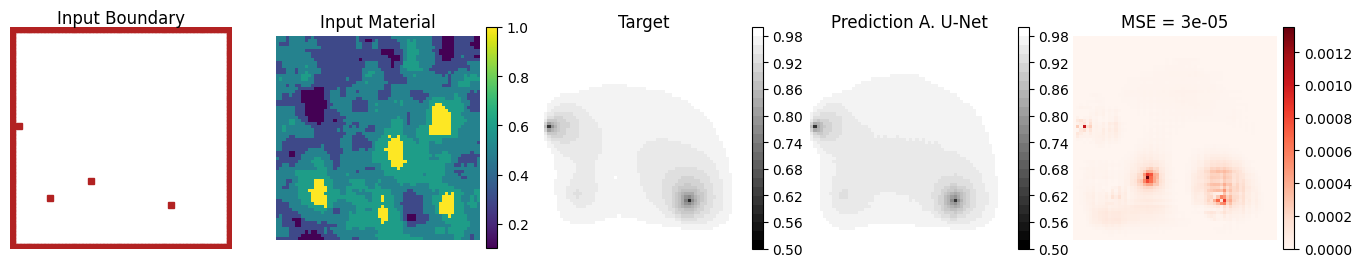

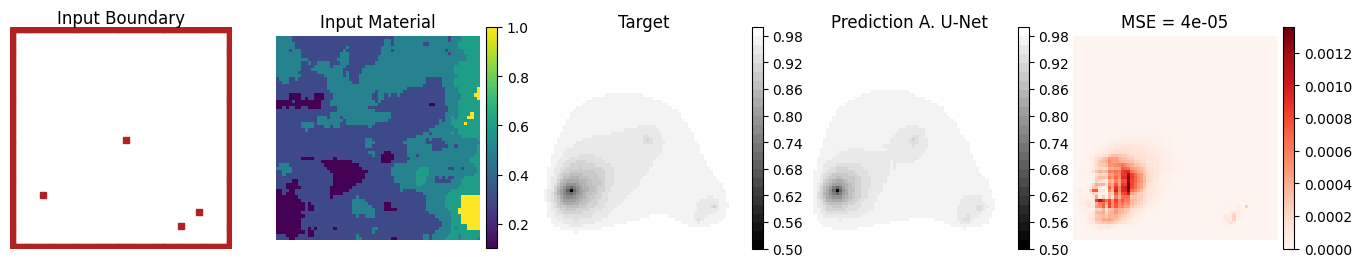

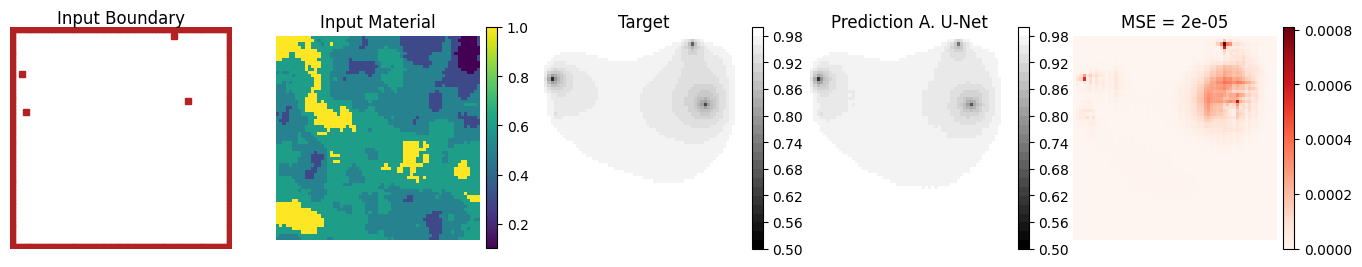

In [ ]:
def plot_IO(input, output, fixed,resize, show_Unet=True, UQ = False):

    if not fixed:
      if UQ:
        no = 6
        title = ['Input Boundary','Input Material','Target','Mean A. U-Net', 'Std A. U-Net']
      else:
        no = 6
        title = ['Input Boundary','Input Material','Target', 'Prediction A. U-Net', 'Error']
    else:
        no = 3
    
    bounds = np.linspace(0.5, 1, 26)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(20,15))
    count = 1
    ax2 = plt.subplot(1, no, count)
    im = ax2.spy(input[:, :, 1], markersize=5, precision=0.1, origin="lower", color = 'firebrick')
    plt.title(title[count-1], y=0.98)
    plt.axis('off')
    count += 1
    if not fixed:
        ax3 = plt.subplot(1, no, count)
        plt.title(title[count-1])
        im = ax3.imshow(input[:, :, 2])
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        count += 1

    ax4 = plt.subplot(1, no, count)
    plt.title(title[count-1])
    im = ax4.imshow(output[:, :, 0], norm=norm,cmap= 'gray')
    plt.axis('off')
    plt.colorbar(im,fraction=0.05, pad=0.03)

    if show_Unet:
      count += 1
      ax5 = plt.subplot(1, no, count)
      plt.title(title[count-1])
      if resize:
        image = input[tf.newaxis, ...]
        image_resized = tf.image.resize(image[0], [64,64])
        start = time.time()
        prediction = model(image_resized[None,:,:,:]).numpy()
        end = time.time()
        # print("The time taken for A-Unet is ",end - start)
        prediction_resized = tf.image.resize(prediction[0], [image.shape[1],image.shape[2]])
        im = ax5.imshow(prediction[0,:,:,0], norm=norm, cmap= 'gray')
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)

      elif UQ:
        UQ_runs= [] 
        for i in range(1000):
          prediction = model(input[None,:,:,:], training = True).numpy()
          UQ_runs.append(prediction[0,:,:,:])   
        mean_modflow = np.mean(UQ_runs, axis = 0)
        std_modflow = np.std(UQ_runs, axis = 0)
        bounds = np.linspace(0, 0.014, 8)
        norm_std = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

        im = ax5.imshow(mean_modflow[:,:,0], norm=norm, cmap= 'gray')
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        count += 1
        ax6 = plt.subplot(1, no, count)
        plt.title(title[count-1])
        im = ax6.imshow(std_modflow[:,:,0], cmap=cm.jet)
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)

      else:
        start = time.time()
        prediction = model(input[None,:,:,:]).numpy()
        end = time.time()
        # print("The time taken for A-Unet is ",end - start)
        im = ax5.imshow(prediction[0,:,:,0], norm=norm, cmap= 'gray')
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        
        count += 1

        
        ax5 = plt.subplot(1, no, count)
        reserr = output[:, :, 0] - prediction[0,:,:,0]
        mse = tf.reduce_mean(tf.square(reserr))
        im = ax5.imshow(tf.square(reserr), cmap= 'Reds')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        plt.axis('off')
        plt.title("MSE = {:.0e}".format(mse))
        # plt.title(title[count-1])

    plt.axis('scaled')
    plt.show()
    return 

name = 'mf6ai'
h1 = 1
N = 64
L = 64.0
minK = 0.1
maxK = 1
n_intervals = 5
fixed = False
k = None
if N==64:
  resize = False
else:
  resize = True

mf6 = modflow6(name, h1, N, L, k=k, minK=0.1, maxK=1, n_intervals= n_intervals, n_wells=5) # h_wells = [0.7], wells_pos=[[32,32]], n_wells=1 

folder = [[], [], []]
for iter in range(3):
    data = mf6.run()
    input_arr, output_arr = next(data)
    start = time.time()
    prediction = model(input_arr[None,:,:,:]).numpy()
    end = time.time()
    # print("The time taken for A-Unet is ",end - start)
    
    folder[0].append(input_arr)
    folder[1].append(output_arr)
    folder[2].append(prediction[0,:,:,:])   

    plot_IO(input_arr, output_arr, fixed, resize, show_Unet=True, UQ= False)

In [ ]:
input_arr.shape

(64, 64, 3)

In [ ]:
gen = ['base' ,'3interv', '10interv', '4wells', '10wells']
evaluation = [] 
evaluation_noatt = []
for filename in (gen):
    if filename == 'base':
      data_name = "40000_samples.npz"
    else:
      data_name = "{}_generalization.npz".format(filename)

    with np.load(os.path.join(path, data_name)) as data:
        test_examples = tf.cast(data['x_test'], tf.float32)
        test_labels = tf.cast(data['y_test'], tf.float32)
        evaluation.append([filename] + model.evaluate(test_examples, test_labels)) #, verbose=1
        evaluation_noatt.append([filename] + model_noatt.evaluate(test_examples, test_labels))

df = pd.DataFrame(evaluation, columns=['scenario','loss','RMSE','coeff_determination','MSE Loss','custom_max'])
df_noatt = pd.DataFrame(evaluation_noatt, columns=['scenario','loss','RMSE','coeff_determination','MSE Loss','custom_max'])

df['scenario'] = ['base case' , '3 intervals', '10 intervals', '4 wells', '10 wells']
df_noatt['scenario'] = ['base case', '3 intervals', '10 intervals', '4 wells', '10 wells']

32/32 [==============================] - 2s 54ms/step - loss: 1.5260e-04 - RMSE: 0.0124 - coeff_determination: 0.9648 - MSE Loss: 1.5260e-04 - custom_max: 0.1421


In [ ]:
df['scenario'] = ['3 intervals', '10 intervals', '4 wells', '10 wells']
df_noatt['scenario'] = ['3 intervals', '10 intervals', '4 wells', '10 wells']

In [ ]:
pd.set_option('display.float_format', lambda x: '%.1e' % x)
print(df['MSE Loss'])

0   6.6e-05
1   7.3e-05
2   6.1e-05
3   2.1e-04
4   8.3e-04
Name: MSE Loss, dtype: float64


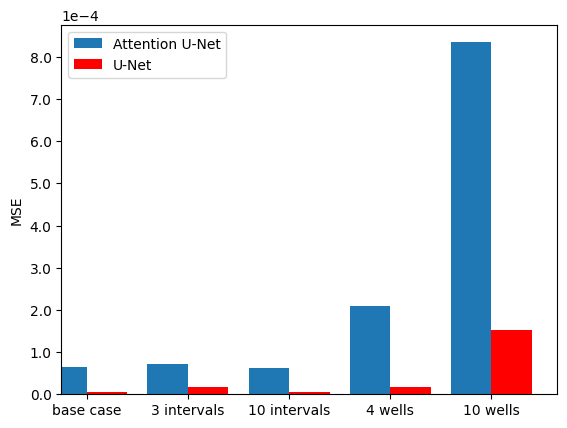

In [ ]:
import matplotlib.ticker as mtick
width = 0.4
ax = df.plot.bar(x='scenario', y='MSE Loss', rot=0, position=1, width = width, label='Attention U-Net')
df_noatt.plot.bar(x='scenario', y='MSE Loss', rot=0, ax=ax, color='red', position=0, width= width, label='U-Net')
ax.set_ylabel('MSE')
ax.set_xlabel('')
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(OOMFormatter(-4, mathText=False))

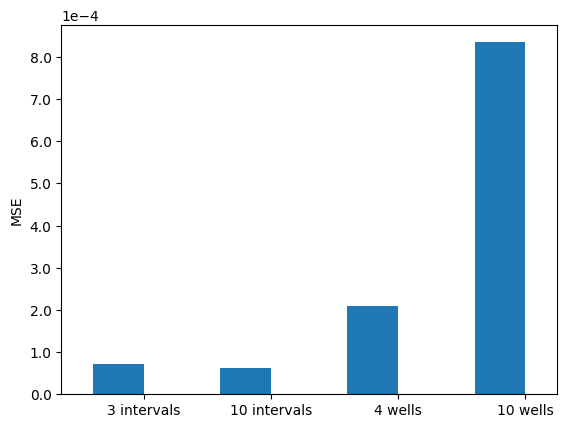

In [ ]:
import matplotlib.ticker as mtick
width = 0.4
ax = df.iloc[1: , :].plot.bar(x='scenario', y='MSE Loss', rot=0, position=1, width = width, label='Attention U-Net')
# df_noatt.plot.bar(x='scenario', y='MSE Loss', rot=0, ax=ax, color='red', position=0, width= width, label='U-Net')
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.get_legend().remove()

# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(OOMFormatter(-4, mathText=False))

In [ ]:
# df.to_csv('gener_att.csv')
# from google.colab import files
# files.download("gener_att.csv")
# df_noatt.to_csv('gener_noatt.csv')
# files.download("gener_noatt.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_IO(input, output, fixed,resize, show_Unet=True, UQ = False):

    if not fixed:
      if UQ:
        no = 8
        title = ['Input Boundary','Input Material','Target','Mean U-Net', 'Std U-Net', 'Mean A. U-Net', 'Std A. U-Net']
      else:
        no = 5
        title = ['Input Boundary','Input Field','Target', 'Prediction']
    else:
        no = 3
    
    bounds = np.linspace(0.5, 1, 26)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(34,15))
    count = 1
    ax2 = plt.subplot(1, no, count)
    im = ax2.spy(input[:, :, 1], markersize=5, precision=0.1, origin="lower", color = 'firebrick')
    plt.title(title[count-1], y=0.98)
    plt.axis('off')
    count += 1
    if not fixed:
        ax3 = plt.subplot(1, no, count)
        plt.title(title[count-1])
        im = ax3.imshow(input[:, :, 2])
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        count += 1

    ax4 = plt.subplot(1, no, count)
    plt.title(title[count-1])
    im = ax4.imshow(output[:, :, 0], norm=norm, cmap = 'gray')
    plt.axis('off')
    plt.colorbar(im,fraction=0.05, pad=0.03)

    if show_Unet:
      count += 1
      ax5 = plt.subplot(1, no, count)
      plt.title(title[count-1])
      if resize:
        image = input[tf.newaxis, ...]
        image_resized = tf.image.resize(image[0], [64,64])
        start = time.time()
        prediction = model(image_resized[None,:,:,:]).numpy()
        end = time.time()
        # print("The time taken for A-Unet is ",end - start)
        prediction_resized = tf.image.resize(prediction[0], [image.shape[1],image.shape[2]])
        im = ax5.imshow(prediction[0,:,:,0], norm=norm)
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)

      elif UQ:
        UQ_runs= [] 
        UQ_runs_noatt= [] 
        for i in range(1000):
          prediction = model(input[None,:,:,:], training = True).numpy()
          UQ_runs.append(prediction[0,:,:,:])   
          prediction_noatt = model_noatt(input[None,:,:,:], training = True).numpy()
          UQ_runs_noatt.append(prediction_noatt[0,:,:,:])   
        mean_aunet = np.mean(UQ_runs, axis = 0)
        mean_noatt = np.mean(UQ_runs_noatt, axis = 0)
        std_aunet = np.std(UQ_runs, axis = 0)
        std_noatt = np.std(UQ_runs_noatt, axis = 0)
        bounds = np.linspace(0, 0.014, 8)
        norm_std = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

        im = ax5.imshow(mean_noatt[:,:,0], norm=norm, cmap = 'gray')
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        count += 1
        ax6 = plt.subplot(1, no, count)
        plt.title(title[count-1])
        im = ax6.imshow(std_noatt[:,:,0], cmap=cm.jet, norm = norm_std)
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)

        count += 1
        ax7 = plt.subplot(1, no, count)
        plt.title(title[count-1])

        im = ax7.imshow(mean_aunet[:,:,0], norm=norm, cmap = 'gray')
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
        count += 1
        ax8 = plt.subplot(1, no, count)
        plt.title(title[count-1])
        im = ax8.imshow(std_aunet[:,:,0], cmap=cm.jet, norm = norm_std)
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)

      else:
        start = time.time()
        prediction = model(input[None,:,:,:]).numpy()
        end = time.time()
        # print("The time taken for A-Unet is ",end - start)
        im = ax5.imshow(prediction[0,:,:,0], norm=norm)
        plt.axis('off')
        plt.colorbar(im,fraction=0.05, pad=0.03)
    plt.axis('scaled')
    plt.show()
    return 

name = 'mf6ai'
h1 = 1
N = 64
L = 64.0
minK = 0.1
maxK = 1
n_intervals = 5
fixed = False
k = None
if N==64:
  resize = False
else:
  resize = True

mf6 = modflow6(name, h1, N, L, k=k, minK=0.1, maxK=1, n_intervals= n_intervals) # h_wells = [0.7], wells_pos=[[32,32]], n_wells=1 

folder = [[], [], []]
for iter in range(5):
    data = mf6.run()
    input_arr, output_arr = next(data)
    start = time.time()
    prediction = model(input_arr[None,:,:,:]).numpy()
    end = time.time()
    # print("The time taken for A-Unet is ",end - start)
    
    folder[0].append(input_arr)
    folder[1].append(output_arr)
    folder[2].append(prediction[0,:,:,:])   

    plot_IO(input_arr, output_arr, fixed, resize, show_Unet=True, UQ= True)

In [ ]:
import os
import seaborn as sns
import pandas as pd

x = 32
y= 10
val_moflow = []
val_aunet = []
for i in range(1000):
    val_moflow.append(folder[1][i][x,y,0])
    val_aunet.append(folder[2][i][x,y,0])


# sns.histplot(data=val_moflow, color="skyblue", kde=True)
# sns.histplot(data=val_aunet, kde=True)

ax = sns.kdeplot(val_moflow, color="skyblue", label = 'Modflow')
ax.lines[0].set_linestyle("--")
sns.kdeplot(val_aunet, color="r", label = 'Attention U-Net')
plt.legend()